# Simulations with PyHEADTAIL

## Imports

In [25]:
import PyHEADTAIL

In [26]:
from PyHEADTAIL.trackers.wrapper import LongWrapper
from PyHEADTAIL.trackers.transverse_tracking import TransverseSegmentMap

In [27]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib tk

import matplotlib.image as mpimg

from scipy.constants import c, e, m_p

from matplotlib import animation, rc
from matplotlib.patches import Ellipse
from IPython.display import HTML

In [28]:
from PyCERNmachines.CERNmachines import PS

## Defining several parameters of the accelerator

Among other things, the number of segments per turn is implemented here

In [45]:
Ekin = 1.4e9
gamma = 1 + Ekin * e /(m_p*c**2)
beta = np.sqrt(1-gamma**-2)

Q_x = 6.23
Q_y = 6.24

# The number of segments is defined here.
machine = PS(n_segments=200, gamma=gamma, machine_configuration = 'LHCbeam_h7',
            longitudinal_focusing = 'non-linear', Q_x=Q_x, Q_y=Q_y)

Synchrotron init. From kwargs: machine_configuration = 'LHCbeam_h7'
Synchrotron init. From kwargs: Q_y = 6.24
Synchrotron init. From kwargs: n_segments = 200
Synchrotron init. From kwargs: gamma = 2.4921045053287254
Synchrotron init. From kwargs: Q_x = 6.23


In [46]:
machine.longitudinal_map.pop_kick(1)
machine.longitudinal_map.phi_offsets[0] += np.pi

## Defining several parameters for the bunch/simulation

Defining the number of turns

In [47]:
n_turns = 1

Defining other parameters

In [48]:
n_macroparticles = 1000
intensity = 1.6e12
epsn_x = epsn_y = 2.5e-6
sigma_z = 185e-9/4*beta*c

bunch = machine.generate_6D_Gaussian_bunch_matched(
    n_macroparticles=n_macroparticles, intensity=intensity, epsn_x=epsn_x,
    epsn_y=epsn_y, sigma_z=sigma_z)

*** Maximum RMS bunch length 14.14653369562553m.
... distance to target bunch length: -1.2573e+01
... distance to target bunch length: 1.0562e+00
... distance to target bunch length: 9.8532e-01
... distance to target bunch length: -5.6875e-01
... distance to target bunch length: 4.1787e-01
... distance to target bunch length: 1.1448e-01
... distance to target bunch length: -8.8436e-03
... distance to target bunch length: 5.5485e-04
... distance to target bunch length: 2.5097e-06
... distance to target bunch length: -1.3242e-05
--> Bunch length: 12.700169357977446
--> Emittance: 1.2136287277619604


In [49]:
rfsystems = machine.longitudinal_map
rfbucket = rfsystems.get_bucket(bunch)

In [50]:
rfsystems._elements.append(
    LongWrapper(machine.circumference))

Defining arrays to save the values of the simulation

In [51]:
x_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
z_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)
dp_rec = np.empty((n_turns*machine.n_segments, bunch.macroparticlenumber), dtype=np.float64)

## Simulation calculations

In [52]:
j = 0

for i in range(n_turns):
    for m in machine.one_turn_map:
        if isinstance(m, TransverseSegmentMap):
            x_rec[j, :] = bunch.x
            y_rec[j, :] = bunch.y
            z_rec[j, :] = bunch.z
            dp_rec[j, :] = bunch.dp
            j += 1
        m.track(bunch)

### Animating the video of the transversal motion

In [53]:
!mkdir Video_Transversal_Motion_Mean_and_Ellipse

mkdir: cannot create directory `Video_Transversal_Motion_Mean_and_Ellipse': File exists


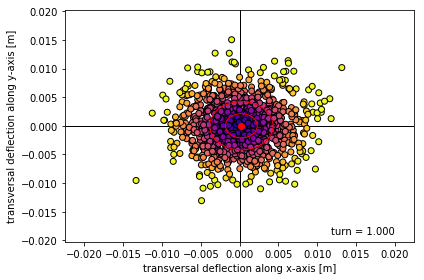

In [66]:
!rm Video_Transversal_Motion_Mean_and_Ellipse/*

zz = np.linspace(rfbucket.z_left - 3 * np.diff(rfbucket.interval), 
                 rfbucket.z_right + 3 * np.diff(rfbucket.interval), 
                 num=1000)
dp_max = rfbucket.separatrix(0)
dpp = np.linspace(-dp_max*1.4, dp_max*1.4, num=100)
ZZ, DPP = np.meshgrid(zz, dpp)
HH = rfbucket.hamiltonian(ZZ, DPP)

for i in range(0, len(x_rec), 1):
    plt.cla()
    x = x_rec[i, :]
    y = y_rec[i, :]
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    
    plt.scatter(x, y, marker='o', c=np.sqrt(x**2+y**2), edgecolor='black',
                cmap=plt.get_cmap('plasma'), vmax=0.01)

    plt.xlim(x_rec.min()*1.2, x_rec.max()*1.2)
    plt.ylim(y_rec.min()*1.2, y_rec.max()*1.2)
    
    plt.xlabel('transversal deflection along x-axis [m]')
    plt.ylabel('transversal deflection along y-axis [m]')
    
    # This plots axes at x, y = 0.
    plt.axhline(0, ls='solid', lw=1, c='black', zorder=-1)
    plt.axvline(0, ls='solid', lw=1, c='black', zorder=-1)
    
    # This is the centroid of the bunch.
    plt.scatter(mx, my, marker='o', c='red')
    
    # This plots ellipses around the centroid.
    plt.gca().add_artist(Ellipse((mx,my), sx, sy, edgecolor='red', 
                                 facecolor='none'))
    plt.gca().add_artist(Ellipse((mx,my), 2*sx, 2*sy, edgecolor='red', 
                                 facecolor='none'))
    
    plt.text(0.020, -0.019, 'turn = {:.3f}'.format((i+1)/float(len(x_rec))),
             horizontalalignment = 'right')
    
    plt.tight_layout()
    
    plt.savefig("Video_Transversal_Motion_Mean_and_Ellipse/"
                "src{:05d}.png".format(i), dpi=200, bbox_inches='tight')



In [67]:
!cd Video_Transversal_Motion_Mean_and_Ellipse; ffmpeg -y -pattern_type glob -i "*.png" -c:v msmpeg4v2 -q:v 2 -pix_fmt yuv420p Transversal_Motion_Mean_and_Ellipse.wmv

ffmpeg version N-90661-g52623bc Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-18)
  configuration: --prefix=/afs/cern.ch/user/p/papostel/lib/
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 14.100 /  7. 14.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
Input #0, image2, from '*.png':
  Duration: 00:00:08.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1174x777 [SAR 7874:7874 DAR 1174:777], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> msmpeg4v2 (native))
Press [q] to stop, [?] for help
Output #0, asf, to 'Transversal_Motion_Mean_and_Ellipse.wmv':
  Metadata:
    WM/EncodingSettings: Lavf58.11.101
    Stream #0:0: Video: msmpeg4v2 (MP42 / 0x3234504D), yuv420p, 1174x777 [SAR 1:1 DAR 1174:777], q=2-3

    Last message repeated 29 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 38 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 23 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f3

    Last message repeated 18 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 38 times
[msmpeg4v2 @ 0x321f

    Last message repeated 482 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f3

    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repea

    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffici

    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f3

    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffici

    Last message repeated 32 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 22 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last messa

    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x3

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last messag

    Last message repeated 496 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f3

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last messag

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 38 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeff

    Last message repeated 460 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 26 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @

    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last messag

    Last message repeated 15 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x321f3

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0

    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffici

    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x

    Last message repeated 20 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f34

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 25 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffic

    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 36 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message re

    Last message repeated 499 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 18 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 37 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 24 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x

    Last message repeated 17 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 15 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f34

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 38 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340

    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0

    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 30 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 26 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffi

    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients t

    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 20 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f3

    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340

    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffici

    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffic

    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f3

    Last message repeated 22 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffic

    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffici

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 16 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coeffi

    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 17 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 28 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340

    Last message repeated 20 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 14 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 6 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f3

    Last message repeated 510 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 11 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 8 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coef

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x3

[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last messa

    Last message repeated 13 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 21 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 2 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coeffi

    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 10 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 29 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 12 times
[msmpeg4v2 @ 0x321f

    Last message repeated 509 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 4 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 5 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0

[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 3 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 1 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 9 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct coefficients to -127..127
    Last message repeated 7 times
[msmpeg4v2 @ 0x321f340] warning, clipping 2 dct coefficients to -127..127
[msmpeg4v2 @ 0x321f340] warning, clipping 1 dct co

### We furthermore want to animate the centroid's motion

In [56]:
x_mean = np.mean(x_rec, axis=1)
y_mean = np.mean(y_rec, axis=1)
x_ax = np.empty(len(x_mean))
for i in range(len(x_mean)):
    x_ax[i] = x_mean[0]

In [57]:
!mkdir x-mean-y-mean

mkdir: cannot create directory `x-mean-y-mean': File exists


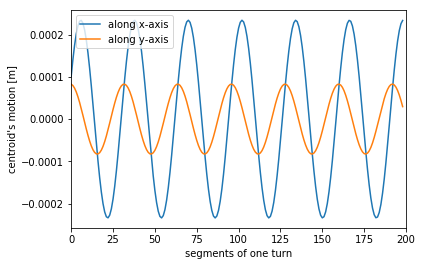

In [58]:
for i in range(len(x_mean)): 
    plt.cla()
    
    plt.plot(x_mean[:i], label='along x-axis')
    plt.plot(y_mean[:i], label='along y-axis')
    
    plt.legend(loc=2)
    
    plt.xlim(0, 200)
    plt.ylim(-x_mean.max()*1.1, x_mean.max()*1.1)
    
    plt.xlabel('segments of one turn')
    plt.ylabel('centroid\'s motion [m]')
    
    plt.savefig("x-mean-y-mean/src{:05d}.png".format(i), dpi=200, bbox_inches='tight')

In [59]:
!cd x-mean-y-mean; ffmpeg -y -pattern_type glob -i "*.png" -c:v msmpeg4v2 -q:v 5 -pix_fmt yuv420p x-mean-y-mean.wmv

ffmpeg version N-90661-g52623bc Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.4.7 (GCC) 20120313 (Red Hat 4.4.7-18)
  configuration: --prefix=/afs/cern.ch/user/p/papostel/lib/
  libavutil      56. 13.100 / 56. 13.100
  libavcodec     58. 17.100 / 58. 17.100
  libavformat    58. 11.101 / 58. 11.101
  libavdevice    58.  2.100 / 58.  2.100
  libavfilter     7. 14.100 /  7. 14.100
  libswscale      5.  0.102 /  5.  0.102
  libswresample   3.  0.101 /  3.  0.101
Input #0, image2, from '*.png':
  Duration: 00:00:08.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 1175x734 [SAR 7874:7874 DAR 1175:734], 25 fps, 25 tbr, 25 tbn, 25 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> msmpeg4v2 (native))
Press [q] to stop, [?] for help
Output #0, asf, to 'x-mean-y-mean.wmv':
  Metadata:
    WM/EncodingSettings: Lavf58.11.101
    Stream #0:0: Video: msmpeg4v2 (MP42 / 0x3234504D), yuv420p, 1175x734 [SAR 1:1 DAR 1175:734], q=2-31, 200 kb/s, 25 fps, 1

### As we did in "Transversal Motion Simulation", we are again plotting a histogram of the intensity distribution now

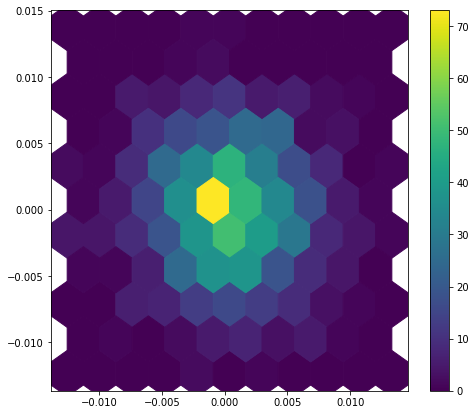

In [22]:
plt.figure(figsize=(8,7))
# plt.hist2d(bunch.x, bunch.y, bins=10);
plt.hexbin(bunch.x, bunch.y, gridsize=10);
plt.colorbar()

## The End